In [4]:
from __future__ import absolute_import, division, print_function
from matplotlib.font_manager import _rebuild; _rebuild()
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

#Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as spio
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix 
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from scipy import interp

tf.logging.set_verbosity(tf.logging.INFO)

Using TensorFlow backend.


In [5]:
"""Set all global parameters to be monitored"""

n_splits = 4
factor_red = 1

# choice of the number of features kept after PCA
nb_feats = 70

# To choose how to split the samples: randomly (1) or chronologically (2)
method_split = 'chronological' # RANDOM or CHRONOLOGICAL

# To choose how to assess the performance of the classifier: with AUC or accuracy
method_metrics = 1 # 1 for AUC, 2 for ACCURACY

In [6]:
"""Set sthe animal ID"""

animal_name = 'sKH03'

In [14]:
"""Load the dataset and set randomness."""
# (from Emma's code)

# Initialize random number generator for reproducibility.
seed = 7
np.random.seed(seed)

# import file into a dictionary
data = spio.loadmat('D:\\Project with Senan\\Stim data 190310\\labeleddat\\with 16 channels\\SPES only - all seizures\\sKH03 - part1\\features_sKH03_2019-06-27_5min_highPass_goodChan.mat')

# get the fields
features = data['features'][()]
labels = data['labels'][()]

print(features.shape)
print(labels.shape)

(6366, 88)
(6366, 1)


In [15]:
"""Reduce the number of classes: delete the seizures - Prediction model"""

a = np.where(labels == 2)

labels_tmp = np.delete(labels, a)
features_tmp = np.delete(features, a, 0);
animal_labels = labels_tmp
animal_features = features_tmp

print(animal_labels.shape)
print(animal_features.shape)

(6279,)
(6279, 88)


In [16]:
"""if method = RANDOM: Shuffling the data to train/test on smaller subsets"""

if method_split == 'random':
    shuffled_animal_features = np.empty(animal_features.shape, dtype=animal_features.dtype)
    shuffled_animal_labels = np.empty(animal_labels.shape, dtype=animal_labels.dtype)
    permutation = np.random.permutation(len(animal_labels))
    for old_index, new_index in enumerate(permutation):
            shuffled_animal_features [new_index] = animal_features[old_index]
            shuffled_animal_labels[new_index] = animal_labels[old_index]
    animal_features = shuffled_animal_features
    animal_labels = shuffled_animal_labels

In [17]:
"""Reducing the size of the vectors for easier computation"""
factor = factor_red

animal_features = animal_features[0:int(len(animal_features)/factor),:]
animal_labels = animal_labels[0:np.int(len(animal_labels)/factor)]

In [18]:
print(animal_labels.shape)
print(animal_features.shape)

(6279,)
(6279, 88)


## Cross validation loop

Process ended, fold  0
Process ended, fold  1
Process ended, fold  2
Process ended, fold  3


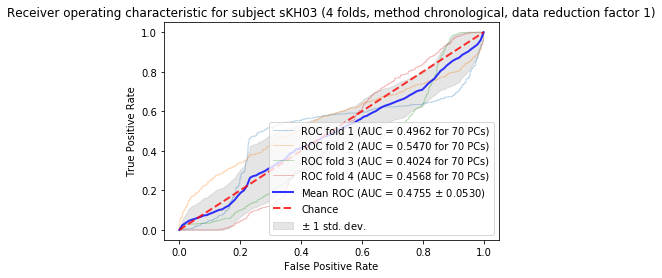

In [19]:
"""Split data into training and testing sets"""

# parameters:
n_splits = n_splits
nb_features_tot = animal_features.shape[1]

cv = StratifiedKFold(n_splits=n_splits, random_state=None, shuffle=False)

if method_metrics == 1:
    AUC = np.zeros(n_splits)
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)
elif method_metrics == 2:
    Acc_test = np.zeros(n_splits)
    Acc_train = np.zeros(n_splits)


"""CV loop"""
k_out = 0
for train, test in cv.split(animal_features, animal_labels):
    data_train = animal_features[train]
    data_test = animal_features[test]
    labels_train = animal_labels[train]
    labels_test = animal_labels[test]
        
    
    """Performance on the test set"""
    
    if method_metrics == 1:
        clf = make_pipeline(StandardScaler(), PCA(n_components=int(nb_feats)), svm.SVC(kernel='rbf', gamma='scale', probability=True))
        y_score = clf.fit(data_train, labels_train)
        y_predict = clf.predict_proba(data_test)
        y_predict_train = clf.predict_proba(data_train)
        """ROC curve"""
        fpr, tpr, thresholds = roc_curve(labels_test, y_predict[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        AUC[k_out] = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.4f for %d PCs)' % (k_out+1, AUC[k_out], int(nb_feats)))  
    elif method_metrics == 2:
        clf = make_pipeline(StandardScaler(), PCA(n_components=int(nb_feats)), svm.SVC(kernel='rbf', gamma='scale'))
        y_score = clf.fit(data_train, labels_train)
        y_predict = clf.predict(data_test)
        y_predict_train = clf.predict(data_train)
        Acc_test[k_out] = metrics.accuracy_score(labels_test, y_predict)
        Acc_train[k_out] = metrics.accuracy_score(labels_train, y_predict_train)
    
    print('Process ended, fold ', k_out)
    k_out += 1

if method_metrics == 1:
    """mean ROC curve"""             
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(AUC)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')       

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for subject %s (%d folds, method %s, data reduction factor %d)' % (animal_name, n_splits, method_split, factor_red))
    plt.legend(loc="lower right")
    plt.savefig('ROC_' + animal_name + '.png')  
    plt.show()  
elif method_metrics == 2:
    print("Accuracy test sets: ", Acc_test)
    print("Accuracy train sets: ", Acc_train)